In [1]:
import Pkg
Pkg.activate("..\\..\\juMLia")
using Plots, DataFrames, Random, LinearAlgebra

  Activating project at `d:\Users\gabri\Documents\Data Science & Machine Learning Spring 2025\Lundquist-CMOR438-Spring2025\juMLia`


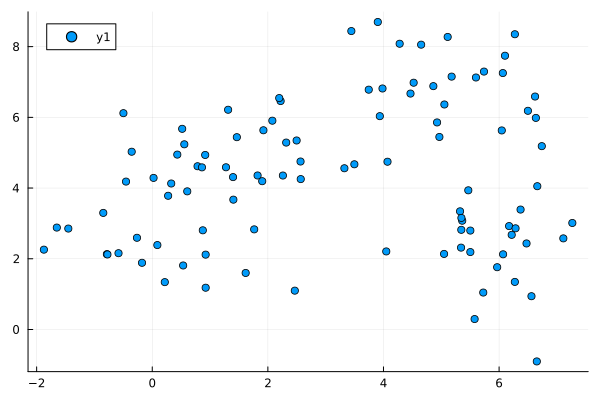

In [16]:
function makeblobs(nsamples, nfeatures, ncenters; centerseparation=10, clusterspread=1, randomstate=0)
    Random.seed!(randomstate)
    pointspercluster = div(nsamples, ncenters)
    X = Array{Float64}(undef, 0, nfeatures)
    y = Int[]
    clusters = Vector{Array{Float64,2}}(undef, ncenters)

    for i in 1:ncenters
        # Randomly place cluster centers
        center = rand(Float64, nfeatures) .* centerseparation
        # Generate points around each center
        clusters[i] = clusterspread .* randn(pointspercluster, nfeatures) .+ center'
        X = vcat(X, clusters[i])
        append!(y, fill(i, pointspercluster))
    end

    return X, y, clusters
end

(points, labels, clusters) = makeblobs(100, 2, 4; centerseparation=7, randomstate=7)
scatter(points[:,1], points[:,2])

Here we create a simple function for making cluster-able blobs: points generated by a normal distribution around centers generated by a uniform distribution. We set it to create 4 clusters.

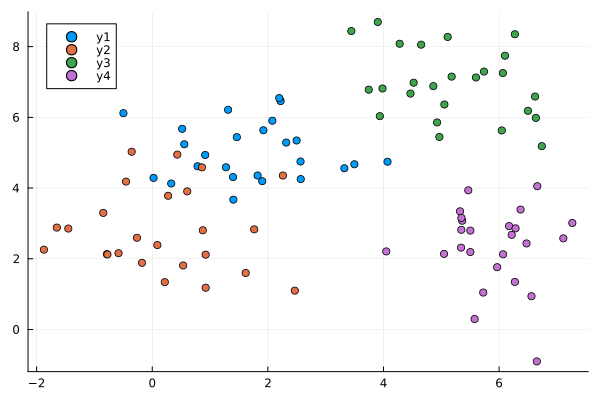

In [17]:
plot()
for cluster in clusters
    scatter!(cluster[:,1], cluster[:,2])
end
plot!()

Here are the clusters as defined by `makeblobs`. 

---

We have to choose a `k` first. We start our clustering in a dumb way: we randomly choose `k` points from our training set as centers. It turns out the algorithm still converges pretty fast even with such a cold start.

We start with `k = 4` to see how well the algorithm does at matching the training data.

In [18]:
k = 4

4

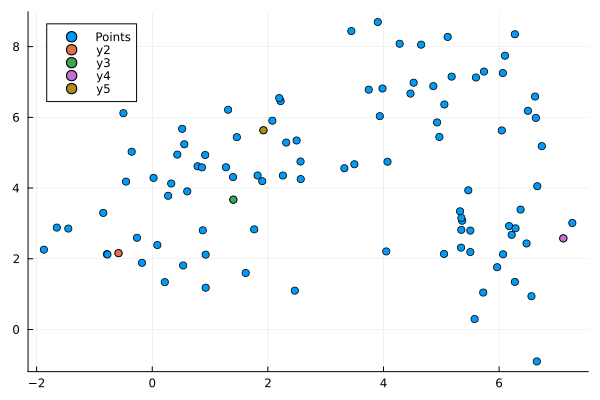

In [19]:
Random.seed!(0)
algcenters = [vec(points[rand(1:100),:]) for _ in 1:k]
scatter(points[:,1], points[:,2], label="Points")
for center in algcenters
    scatter!([center[1]], [center[2]])
end
plot!()

We assign points to centers by whichever center is closest to each point. This requires a distance metric, which is typically the Euclidean norm. 

In [54]:
function assignlabel(point, centers; distmetric=norm)
    distances = map(ctr -> distmetric(point .- ctr), centers)
    return argmin(distances)
end

function clustersfromlabels(points, labels)
    clusters = fill(Array{Float64}(undef, 0, size(points,2)), length(unique(labels)))
    for (ptindex, lbl) in enumerate(labels)
        clusters[lbl] = vcat(clusters[lbl], points[ptindex, :]')
    end
    return clusters
end

function assignclusters(points, centers; distmetric=norm)
    return [assignlabel(points[idx,:], centers) for idx in 1:size(points, 1)]
end

assignclusters (generic function with 1 method)

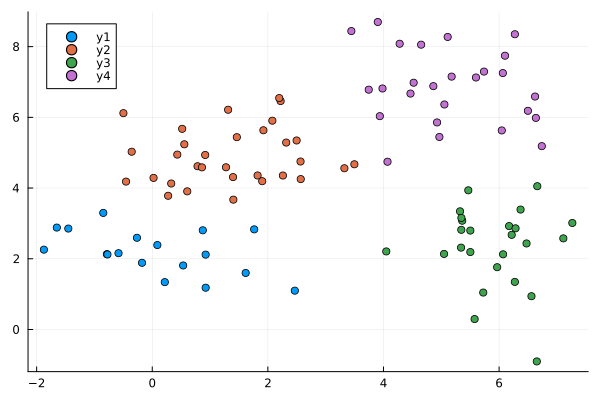

In [55]:
alglabels = assignclusters(points, algcenters)
algclusters = clustersfromlabels(points, alglabels)
plot()
for cluster in algclusters
    scatter!(cluster[:,1], cluster[:,2])
end
plot!()

Having a way to assign clusters to centers, we need a way of updating the centers so that they approach a central position in a cluster. 

We don't "update" in direct reference to the original coordinates of the centers, but rather set the new centers equal to the mean position of each cluster, which in turn was defined by the previous centers. So it's a process of update clusters by proximity of points to centers -> update centers by mean position of clusters.

In [57]:
function updatecenters!(centers, clusters, points)
    nfeatures = size(points, 2)
    k = size(centers, 1)
    newcenters = fill(zeros(nfeatures), k)
    newcenters .+= [vec(sum(clstr, dims=1)) ./ size(clstr, 1) for clstr in clusters]
    return centers .= newcenters
end

function updatecenters!(centers, points)
    clusters = clustersfromlabels(points, assignclusters(points, centers))
    # println(size(clusters))
    nfeatures = size(points, 2)
    k = size(centers, 1)
    newcenters = fill(zeros(nfeatures), k)
    newcenters .+= [vec(sum(clstr, dims=1)) ./ size(clstr, 1) for clstr in clusters]
    return centers .= newcenters
end

updatecenters! (generic function with 2 methods)

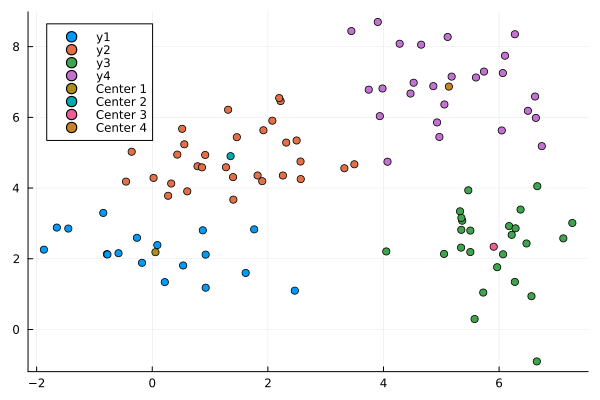

In [58]:
updatecenters!(algcenters, algclusters, points)
alglabels = assignclusters(points, algcenters)
algclusters = clustersfromlabels(points, alglabels)
plot()
for cluster in algclusters
    scatter!(cluster[:,1], cluster[:,2])
end

for (center, label) in zip(algcenters, sort(unique(alglabels)))
    scatter!([center[1]], [center[2]], label="Center $(label)")
end
plot!()

This looks pretty good! Let's check the true clusters again:

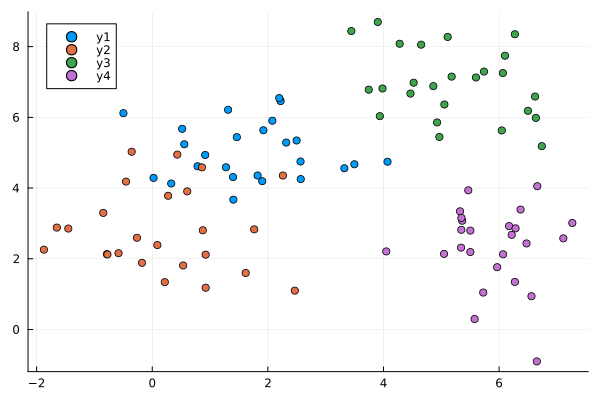

In [59]:
plot()
for cluster in clusters
    scatter!(cluster[:,1], cluster[:,2])
end
plot!()

It only took one iteration of the algorithm to get something very similar to the true clusters. Now unfortunately by nature of unsupervised learning, it's tough to check the classification error against the true group labels--how would we know which learned label to each true label?--but we can use a different measure of error: the within-group distances. This is essentially the loss function down which we descend when we run through the algorithm.

We integrate all of our work into a single function:

In [60]:
function kmeanscluster(X, k; maxiter=100, randseed=0)
    Random.seed!(randseed)
    algcenters = [vec(X[rand(1:100),:]) for _ in 1:k]
    
    for _ in 1:maxiter
        updatecenters!(algcenters, X)
    end

    return algcenters
end

kmeanscluster (generic function with 1 method)

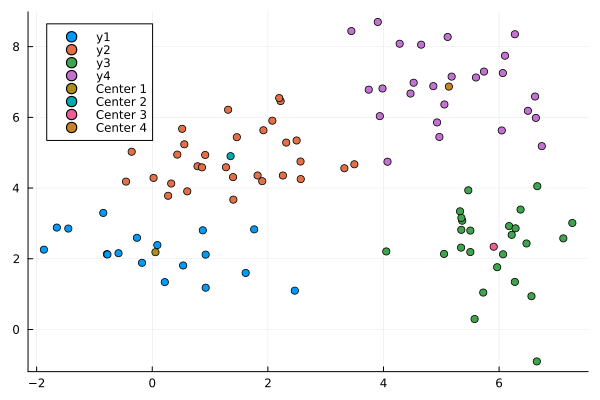

In [61]:
algcenters = kmeanscluster(points, 4)
alglabels = assignclusters(points, algcenters)
algclusters = clustersfromlabels(points, alglabels)
plot()
for cluster in algclusters
    scatter!(cluster[:,1], cluster[:,2])
end

for (center, label) in zip(algcenters, sort(unique(alglabels)))
    scatter!([center[1]], [center[2]], label="Center $(label)")
end
plot!()

Now let's try it for different k...

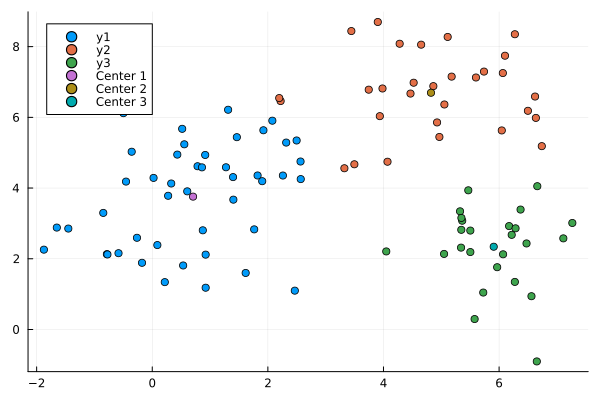

In [63]:
algcenters = kmeanscluster(points, 3)
alglabels = assignclusters(points, algcenters)
algclusters = clustersfromlabels(points, alglabels)
plot()
for cluster in algclusters
    scatter!(cluster[:,1], cluster[:,2])
end

for (center, label) in zip(algcenters, sort(unique(alglabels)))
    scatter!([center[1]], [center[2]], label="Center $(label)")
end
plot!()

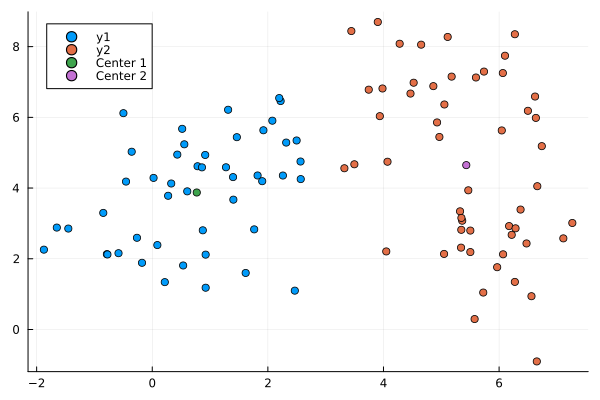

In [64]:
algcenters = kmeanscluster(points, 2)
alglabels = assignclusters(points, algcenters)
algclusters = clustersfromlabels(points, alglabels)
plot()
for cluster in algclusters
    scatter!(cluster[:,1], cluster[:,2])
end

for (center, label) in zip(algcenters, sort(unique(alglabels)))
    scatter!([center[1]], [center[2]], label="Center $(label)")
end
plot!()

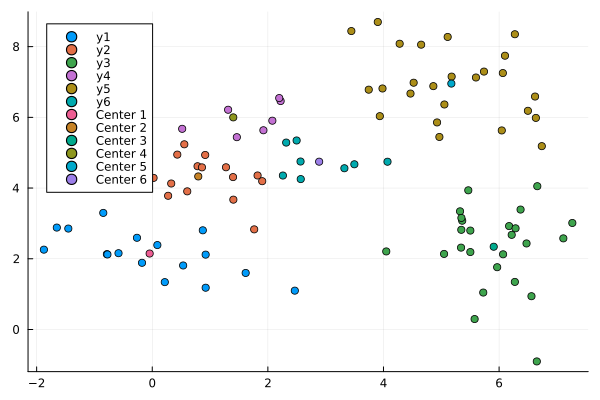

In [65]:
algcenters = kmeanscluster(points, 6)
alglabels = assignclusters(points, algcenters)
algclusters = clustersfromlabels(points, alglabels)
plot()
for cluster in algclusters
    scatter!(cluster[:,1], cluster[:,2])
end

for (center, label) in zip(algcenters, sort(unique(alglabels)))
    scatter!([center[1]], [center[2]], label="Center $(label)")
end
plot!()

The one consideration we have to make is that in most cases we don't know what `k` is before we train on the data. We can't just use within-group distance (variance) as a way to check for the best `k`, because then the ideal `k` is the number of points in the training set. There are many techniques to determine optimal `k`, from the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) (visually locating a poorly-defined feature on a plot of cluster variation over number of clusters) to the [adjusted Rand index](https://en.wikipedia.org/wiki/Rand_index) (a method of comparing two clusterings that considers the number of agreements between them as well as the chance that agreements are by chance).

Worse, splitting the data into a training set and a testing set and then setting `k` according to the heuristic on the testing set risks overfitting! Information from the testing set can't be used to change `k`, because changing `k` is training the model. One solution is to split the data into three sets: a training set, a validation set to find `k`, and a testing set to measure the accuracy of the model.